
# Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a regression activity.

## Workflow
1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Data preparation, according to background information
    1. Set the __target__ variable, according to background information
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [119]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.csv` file and show a short description

In [120]:
url = "regression_example.csv"
data = pd.read_csv(url)
data.head()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
0,0,1.509081,-1.049118,1.978885,1.060733,NaN,0.824655,0.819409,-1.157708,214.593802
1,1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189


## Data Exploration and preparation

##### Show a short description of the columns

In [121]:
data.describe()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
count,843.000000,802.000000,807.000000,812.000000,8.020000e+02,805.000000,808.000000,806.000000,812.000000,813.000000
mean,421.000000,-0.037473,0.008466,-0.059965,9.616777e-01,-0.093113,0.034653,-0.019928,-0.034976,3.798356
std,243.497433,1.038115,0.973884,0.991280,1.286476e+00,1.050385,0.957238,0.997345,0.963010,114.189124
min,0.000000,-3.700229,-2.832440,-4.141473,2.007427e-08,-4.072767,-2.968219,-2.850505,-3.948627,-358.659591
25%,210.500000,-0.723630,-0.640017,-0.681924,8.725649e-02,-0.802553,-0.625219,-0.689671,-0.662887,-73.823652
50%,421.000000,-0.032953,0.005693,-0.050789,4.707895e-01,-0.090512,0.051123,-0.014592,-0.049392,-0.159154
75%,631.500000,0.629368,0.681480,0.587393,1.350123e+00,0.611545,0.689203,0.612939,0.614423,75.487094
max,842.000000,3.043062,2.945731,2.925432,9.200073e+00,3.024952,3.210373,2.861549,3.000174,422.794685


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [122]:
rows = data.shape[0]
rows_without_nan = data.dropna().shape[0]
rows_with_nulls = rows - rows_without_nan
rows_with_nulls

273

#### Drop data that are useless or not usable

In [123]:
# remove rows with null values
data = data.dropna()

# remove idx column
data = data.drop(columns=['idx'])

print(f"Shape of the final dataset: {data.shape[0]} rows and {data.shape[1]} columns")

Shape of the final dataset: 570 rows and 9 columns


In [124]:
data.head()

,F0,F1,F2,F3,F4,F5,F6,F7,response
1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189
5,-0.635465,-1.112850,-0.330580,6.141348,1.914527,0.408895,-0.364722,-0.731382,-261.116572


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [125]:
target = 'response'
X = data.drop(target, axis=1)
y = data[target]

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

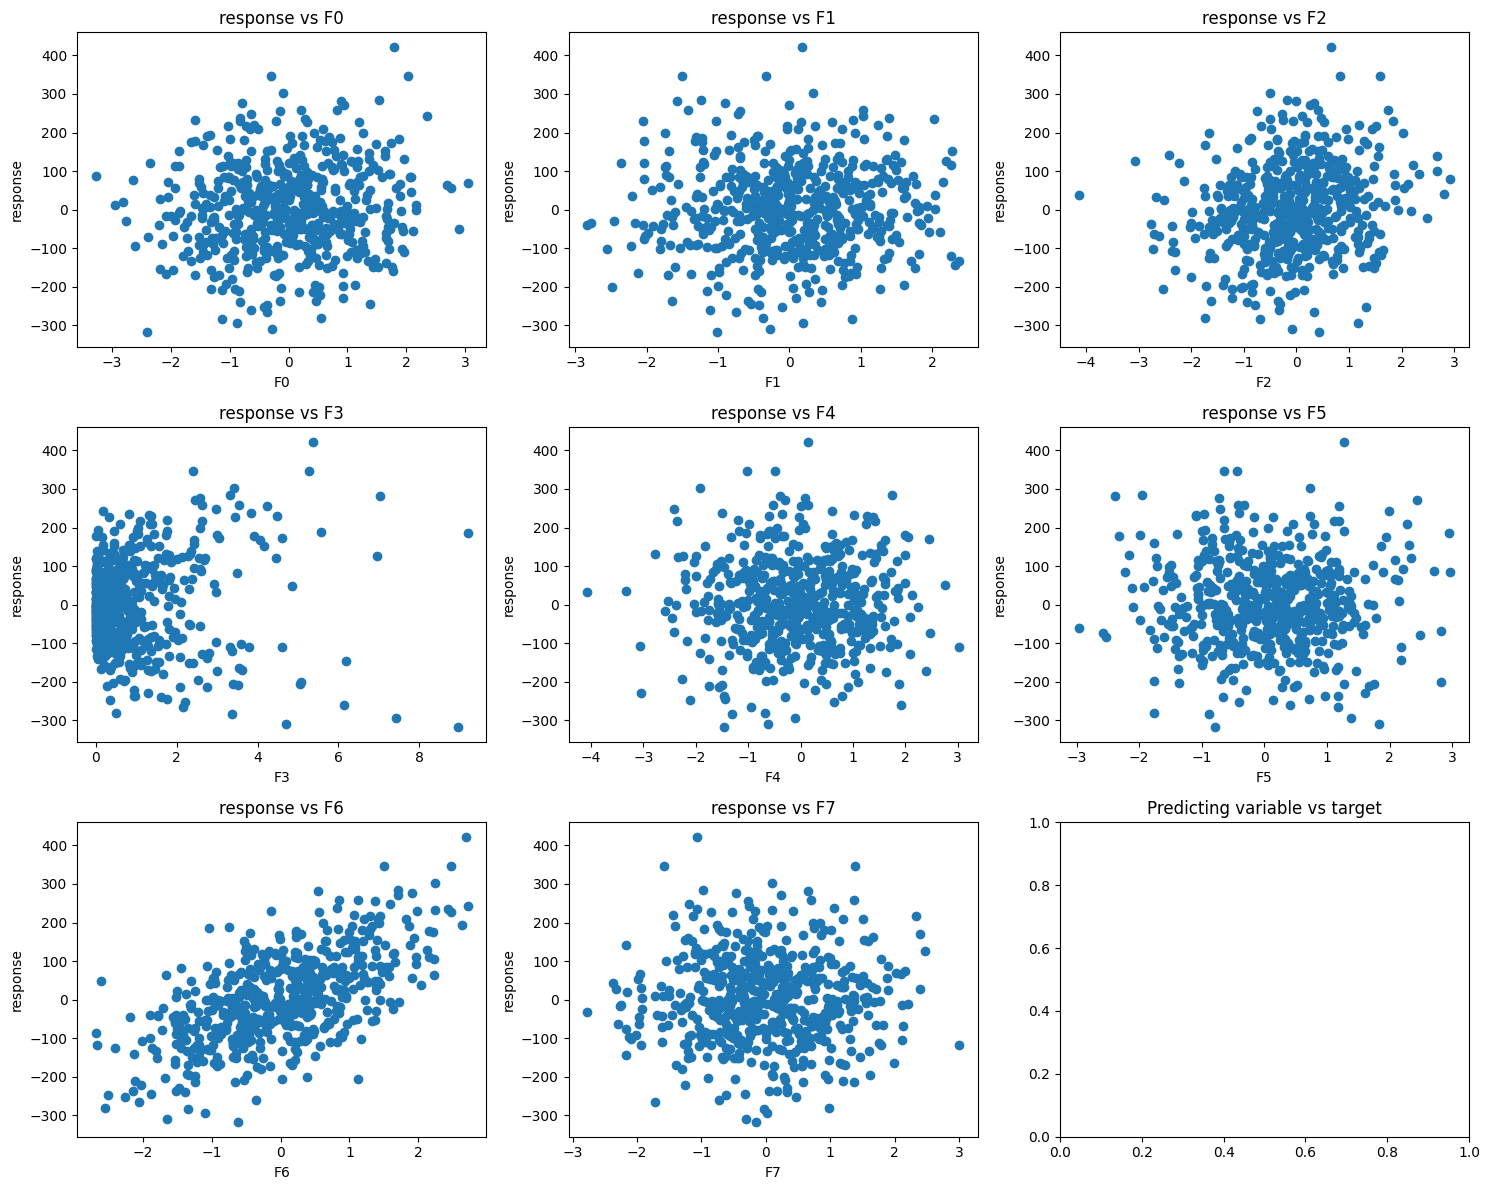

In [126]:
num_cols = 3
num_rows = (X.shape[1] + num_cols - 1) // num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))


for i,predictor in enumerate(X):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].scatter(X[predictor], y)
    axes[row, col].set_title(f'response vs {predictor}')
    axes[row, col].set_xlabel(predictor)
    axes[row, col].set_ylabel('response')

plt.title('Predicting variable vs target')
plt.tight_layout()
plt.show()

<Axes: >

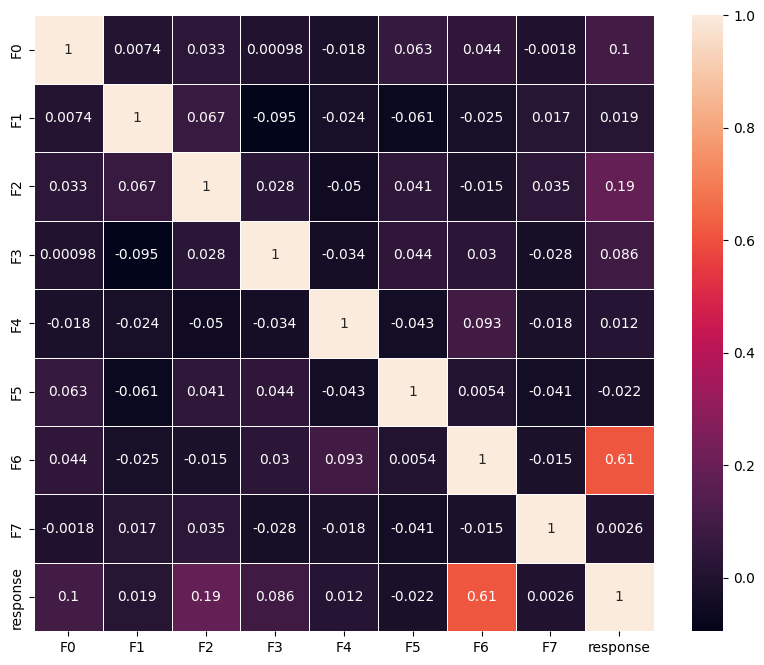

In [127]:
import seaborn as sns
corr_matrix = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)

## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [128]:
train_size = 0.7

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

print(f"There are {X_train.shape[0]} samples in the training set")
print(f"There are {X_test.shape[0]} samples in the test set")

There are 399 samples in the training set
There are 171 samples in the test set


In [129]:
# sort X_test and y_test by F6
X_test = X_test.sort_values(by='F6')
y_test = y_test.loc[X_test.index]

## 2. First experiment - univariate linear regression
We choose the variable exhibiting the highest correlation with respect to the target

Consider a reduced dataset containing the chosen variable and the target

In [130]:
corr_values = corr_matrix['response'].sort_values(ascending=False).drop('response').idxmax()

print(f"Highest correlation is: {corr_values}")

# reduced dataset
f6 = X_train[corr_values].to_frame()

Highest correlation is: F6


### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [131]:
uni = linear_model.LinearRegression()
uni.fit(X=f6, y=y_train)
#print(f"Model coefficients: {model.coef_}")
#print(f"Model intercept: {model.intercept_}")

y_test_uni = uni.predict(X_test[corr_values].to_frame())

#### Compute the quality measures

In [132]:
mse = mean_squared_error(y_test, y_test_dt)
r2 = r2_score(y_test, y_test_dt)
print(f"Mean squared error: {mse}")
print(f"R2 score: {r2}")

Mean squared error: 16008.68416604897
R2 score: -0.4615702024084951


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [133]:
model = linear_model.LinearRegression()
model.fit(X=X_train, y=y_train)

y_test_multi = model.predict(X_test)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [134]:
var = model.feature_names_in_
coef= model.coef_

# create a dataframe with 2 columns: variable and coefficient
df = pd.DataFrame({'variable':var, 'coefficient':coef})
df

,variable,coefficient
0,F0,9.225329
1,F1,2.794846
2,F2,21.766171
3,F3,3.299594
4,F4,-5.532386
5,F5,-6.002884
6,F6,72.949625
7,F7,-2.675824


#### Compute the quality measures

In [135]:
mse = mean_squared_error(y_test, y_test_dt)
r2 = r2_score(y_test, y_test_dt)
print(f"Mean squared error: {mse}")
print(f"R2 score: {r2}")

Mean squared error: 16008.68416604897
R2 score: -0.4615702024084951


## Decision Tree Multivariate Regresson

In [136]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [137]:
model = DecisionTreeRegressor()
model.fit(X=X_train, y=y_train)
fitted_max_depth = model.get_depth()
print(f"Model depth: {fitted_max_depth}")

Model depth: 22


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [138]:
from sklearn.model_selection import GridSearchCV
# Set the parameters to be explored during the rounds of cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)]}]

score = 'r2'
model_grid = GridSearchCV(model, tuned_param_dt, cv=5, scoring=score)
model_grid.fit(X_train, y_train)
y_test_dt = model_grid.predict(X_test)
print(f"The optimal maximum depth for the decision tree is: {model_grid.best_params_['max_depth']}")

The optimal maximum depth for the decision tree is: 2


In [139]:
mse = mean_squared_error(y_test, y_test_dt)
root_mse = np.sqrt(mse).round(2)
print(f"Root mean squared error (RMSE): {root_mse}")

Root mean squared error (RMSE): 89.83


#### Show the tree

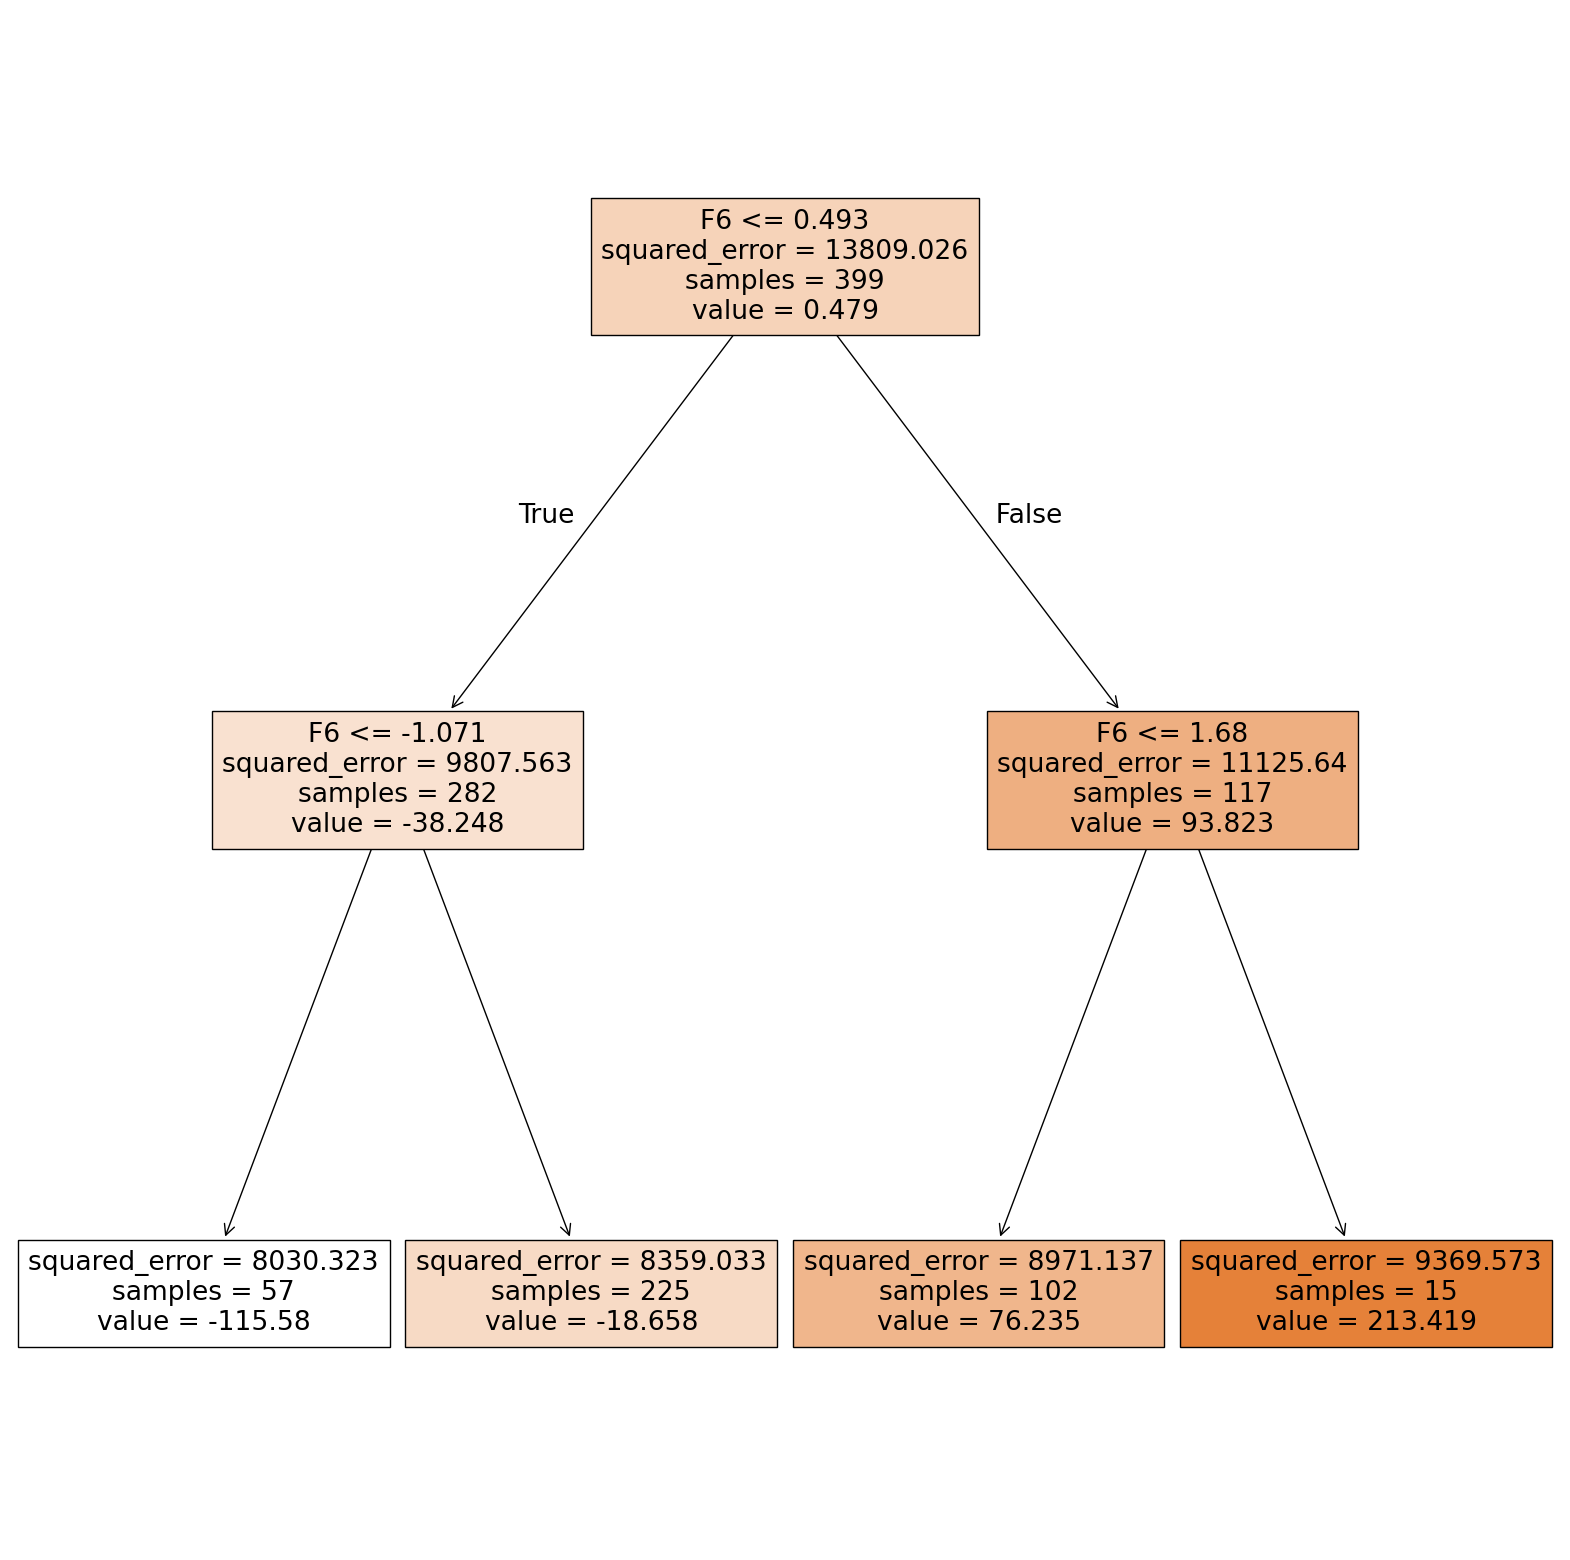

In [140]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

# Visualize the tree
figure(figsize=(20, 20))
plot_tree(model_grid.best_estimator_, filled=True, feature_names=X.columns)
plt.show()

## Random Forest Multivariate Regresson

In [141]:
# Create Random Forest regression object
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=random_state)
model.fit(X=X_train, y=y_train)
fitted_max_depth = max([estimator.get_depth() for estimator in model.estimators_])

from sklearn.model_selection import GridSearchCV
# Set the parameters to be explored during the rounds of cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)]}]

score = 'r2'
model_grid = GridSearchCV(model, tuned_param_dt, cv=5, scoring=score)
model_grid.fit(X_train, y_train)
y_test_rf = model_grid.predict(X_test)
print(f"The optimal maximum depth for the decision tree is: {model_grid.best_params_['max_depth']}")

The optimal maximum depth for the decision tree is: 3


In [142]:
mse = mean_squared_error(y_test, y_test_dt)
root_mse = np.sqrt(mse).round(2)
print(f"Root mean squared error (RMSE): {root_mse}")

Root mean squared error (RMSE): 89.83


### Plot the prediction of every model, compare it with the real test set, and print the metrics $R^2$ and RMSE 

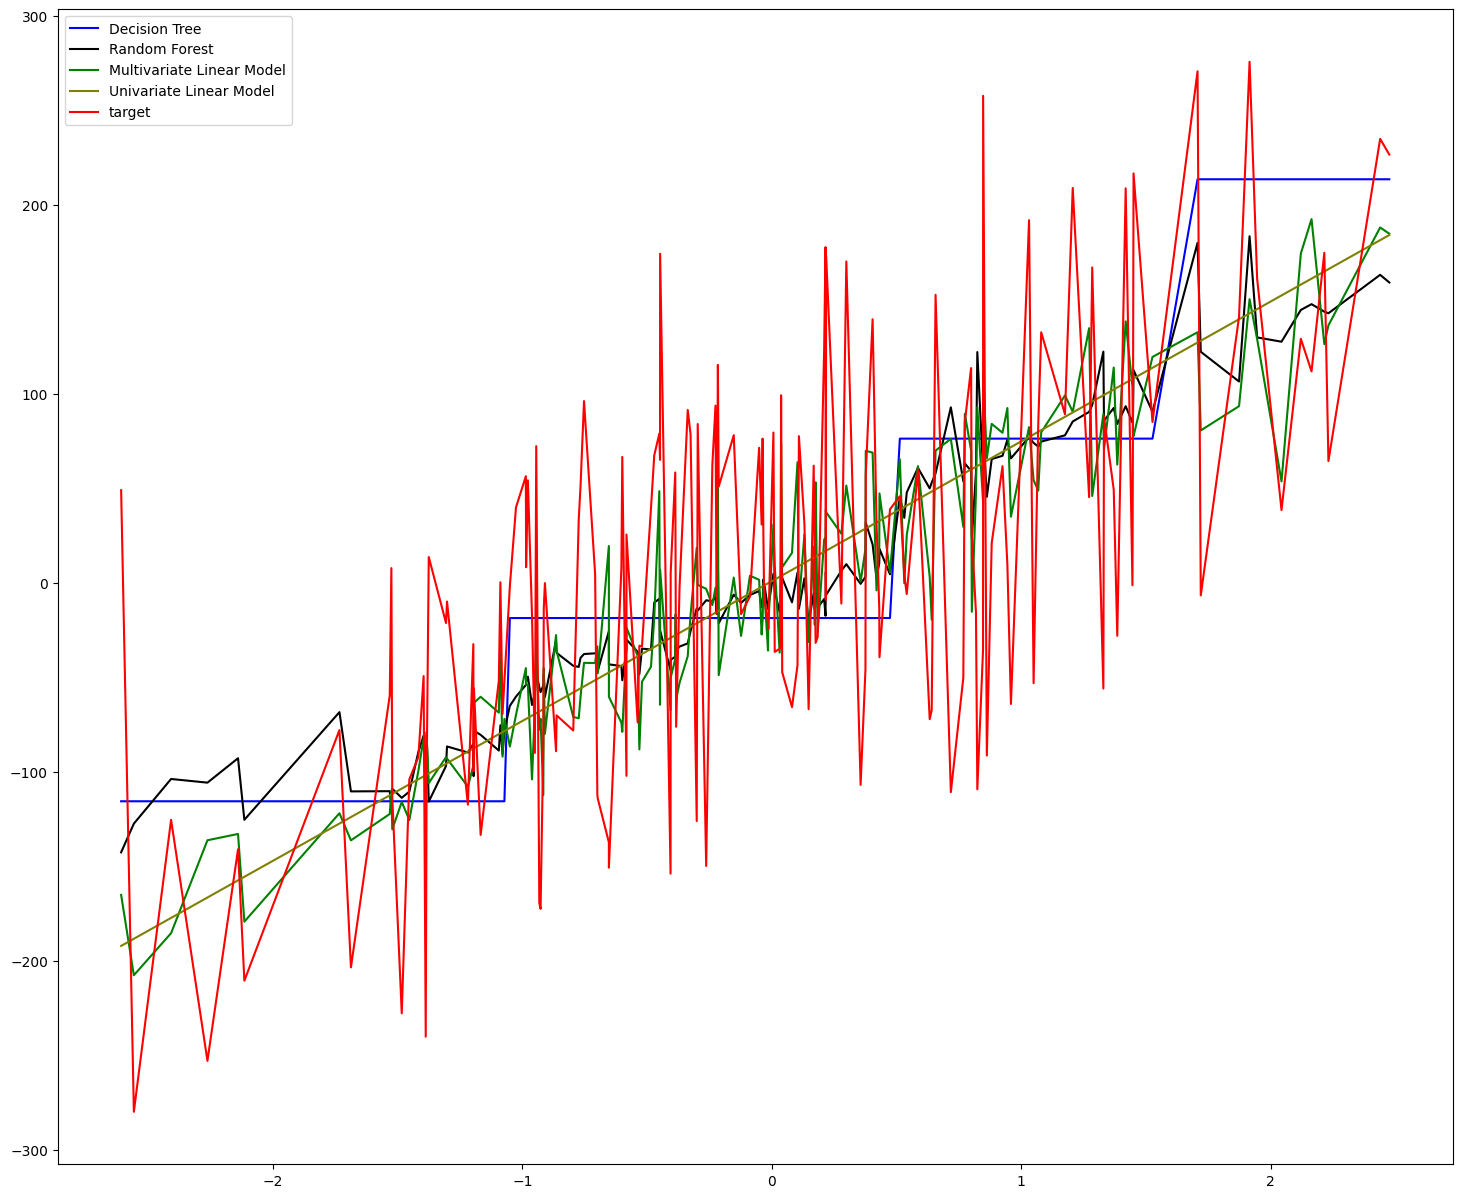

In [153]:
plt.figure(figsize=(18, 15))
plt.plot(X_test['F6'], y_test_dt, label='Decision Tree', color='blue')
plt.plot(X_test['F6'], y_test_rf, label='Random Forest', color='black')
plt.plot(X_test['F6'], y_test_multi, label='Multivariate Linear Model', color='green')
plt.plot(X_test['F6'], y_test_uni, label='Univariate Linear Model', color='olive')
plt.plot(X_test['F6'], y_test, label='target', color='red')
plt.legend()
plt.show()

,Model,RMSE,R_square
0,Linear Univariate on F6,85.122,0.338
1,Linear Multivariate,81.104,0.399
2,Decision Tree Regressor,89.827,nan
3,Random Forest Regressor,84.701,nan


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 

### Decision Tree and Random Forest regression
- Decision Tree and Random Forest have an RMSE slightly higher than multivariate linear regression



## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with other columns and comment the results